In [569]:
import h5py
import pandas as pd
import numpy as np
import os

def parse_timestamp(ts):
    ts = str(ts)
    if len(ts) == 17:
        year = int(ts[0:4])
        month = int(ts[4:6])
        day = int(ts[6:8])
        hour = int(ts[8:10])
        minute = int(ts[10:12])
        second = int(ts[12:14])
        millisecond = int(ts[14:17])
        microsecond = millisecond * 1000
        return pd.Timestamp(year, month, day, hour, minute, second, microsecond)
    else:
        return pd.NaT
    
def vwap(df, level=10, _type="all"):
    if _type == "ask":
        pv = df.apply(lambda row: sum([row[f"AskPrice{str(i)}"]*row[f"AskVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
        v = df.apply(lambda row: sum([row[f"AskVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
    if _type == "bid":
        pv = df.apply(lambda row: sum([row[f"BidPrice{str(i)}"]*row[f"BidVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
        v = df.apply(lambda row: sum([row[f"BidVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
    if _type == "all":
        askvwap, askv = vwap(df, level, _type="ask")
        bidvwap, bidv = vwap(df, level, _type="bid")
        pv, v = askvwap*askv + bidvwap*bidv, askv + bidv
    return pv/v, v

class PPL:
    def __init__(self, base_path="./interview", id="002521"):
        self.base_path = base_path
        self.id = id

    def profiler(self, dayprofiler, kwargs={}, start_date="20220601", end_date="20221013"):
        dates = list(map(lambda x: x.strftime("%Y%m%d"), pd.date_range(start=start_date, end=end_date).tolist()))
        res = []
        res_dates = []
        for date in dates:
            if os.path.exists(f'{self.base_path}/{self.id}_{date}.h5'):
                res_dates.append(date)
                with h5py.File(f'{self.base_path}/{self.id}_{date}.h5', 'r') as f:
                    res.append(dayprofiler(f, **kwargs))
        return pd.concat(res, keys=res_dates, names=["Date"])
    
    @staticmethod
    def get_basic(f, freq="1min"):
        df = pd.DataFrame({
            k: f[k][:] for k in f.keys()
        })
        df["MidPrice"] = (df["AskPrice1"] * df["AskVolume1"] + df["BidPrice1"] * df["BidVolume1"]) / (df["AskVolume1"] + df["BidVolume1"])
        df["Time"] = df["DataTime"].apply(parse_timestamp)
        df.set_index("Time", inplace=True)
        resampled = df.resample(freq).agg(
            {
                "MidPrice" : ["first", "last"],
                "Volume" : ["first", "last"],
            }
        )
        res = pd.DataFrame({
            "open" : resampled["MidPrice"]["first"],
            "close" : resampled["MidPrice"]["last"],
            "volume": resampled["Volume"]["last"] - resampled["Volume"]["first"] 
        })
        res["Time"] = res.index.strftime("%H%M%S")
        res = res.set_index("Time").dropna(how="all")
        res.iloc[0]["volume"] = resampled["Volume"]["last"].iloc[0]
        return res
    
    @staticmethod
    def get_close(f):
        df = pd.DataFrame({
            k: f[k][:] for k in f.keys()
        })
        df["MidPrice"] = (df["AskPrice1"] * df["AskVolume1"] + df["BidPrice1"] * df["BidVolume1"]) / (df["AskVolume1"] + df["BidVolume1"])
        
        return pd.DataFrame({
            "close": np.array([df["MidPrice"].iloc[-1]])
        })


## Data preparation

At each time point, I compute the midprice using the volume-weighted average of AskPrice1 and BidPrice1. Each day, I choose a time interval, like 1 minute, and record the first and last midprice as the open and close prices for that interval.

In [570]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 1000)

## Is Overnight return momentum or reversal for intraday return?

Based on the paper "A Tug of War: Overnight versus Intraday Expected Returns," some stocks exhibit a pattern where the overnight return reflects market sentiment and may involve overreactions. These are often corrected during the following intraday trading, leading to a negative relationship between overnight and intraday returns. In contrast, other stocks with little sentiment show a positive relationship between these returns.

I customized the correlation function to not minus the mean and calculated the quasi-correlation between the overnight return and intraday returns.

In [571]:
# custom the quasi-correlation function to not minus the mean
def custom_corr(x, y):
    return np.sum(x * y) / (np.sqrt(np.sum(x**2)) * np.sqrt(np.sum(y**2)))

# rolling quasi-correlation
def rolling_corr(a,b, window_size=10):
    results = [custom_corr(a[i-window_size:i], b[i-window_size:i]) if i >= window_size else np.nan for i in range(len(a))]
    return pd.Series(results, index=a.index)

In [572]:
def get_data(id, freq="30min"):
    ppl = PPL(id=id)
    df = ppl.profiler(PPL.get_basic, kwargs={"freq":freq})
    df["return"] = (df["close"] - df["open"])/df["open"]
    close = ppl.profiler(PPL.get_close).reset_index(level=1, drop=True)
    df["preclose"] = df.index.get_level_values(0).map(close["close"].shift(1))
    df["ovnreturn"] = df.index.get_level_values(0).map(df.xs("093000", level="Time").apply(lambda row: row["open"]/row["preclose"] - 1, axis=1))
    df["ovnreturn"] = df["ovnreturn"].fillna(0)

    corrs = pd.DataFrame({"quasi-correlation with overnight return" : df.groupby(level="Time").apply(lambda group: custom_corr(group["return"], group["ovnreturn"]))})
    corrs.loc["intraday"] =  custom_corr(df["return"].groupby(level="Date").sum(), df["ovnreturn"].groupby(level="Date").apply(lambda row: row.iloc[0]))
    return df, corrs

**Stock "002521"**

In [573]:
_, corrs = get_data("002521")
corrs

,quasi-correlation with overnight return
Time,
093000,-0.229486
100000,-0.074137
103000,0.120706
110000,-0.094204
130000,0.010393
133000,-0.143734
140000,0.166411
143000,0.087680
intraday,-0.137084


Based on the data in the table, we observe that stock "002521" exhibits strong market sentiment, characterized by a significant negative correlation between its overnight return and intraday return. This negative correlation becomes more pronounced closer to the market opening.

**Stock "300132"**

In [574]:
_, corrs = get_data("300132")
corrs

,quasi-correlation with overnight return
Time,
093000,0.158970
100000,0.158819
103000,0.089365
110000,-0.205482
130000,0.050547
133000,0.005217
140000,0.271869
143000,0.024378
intraday,0.223596


Based on the data in the table, we observe that stock "300132" exhibits little market sentiment, characterized by a significant positive correlation between its overnight return and intraday return.

I calculated the past 10 days quasi-correlation and calculate the moving average of 10 days to represent whether the stock has market sentiment.

Leveraging the above finding, we can design a trading strategy:

1. When the moving average of quasi-correlation is positive: (overnight momentum strategy)

- Buy Position: Purchase the stock at the open when the overnight return is greater than 0.006 and sell it at the close of the day.

- Short Position: Sell short the stock at the open when the overnight return is less than -0.006 and buy it back at the close of the day.

2. When the moving average of quasi-correlation is negative: (overnight inverse strategy)

- Buy Position: Purchase the stock at the open when the overnight return is less than -0.006 and sell it at the close of the day.

- Short Position: Sell short the stock at the open when the overnight return is greater than 0.006 and buy it back at the close of the day.

The overall trading costs include a transaction fee of 0.0014 plus a bid-ask spread of 0.002, as confirmed upon examination. Below, I have plotted the cumulative return of this strategy:


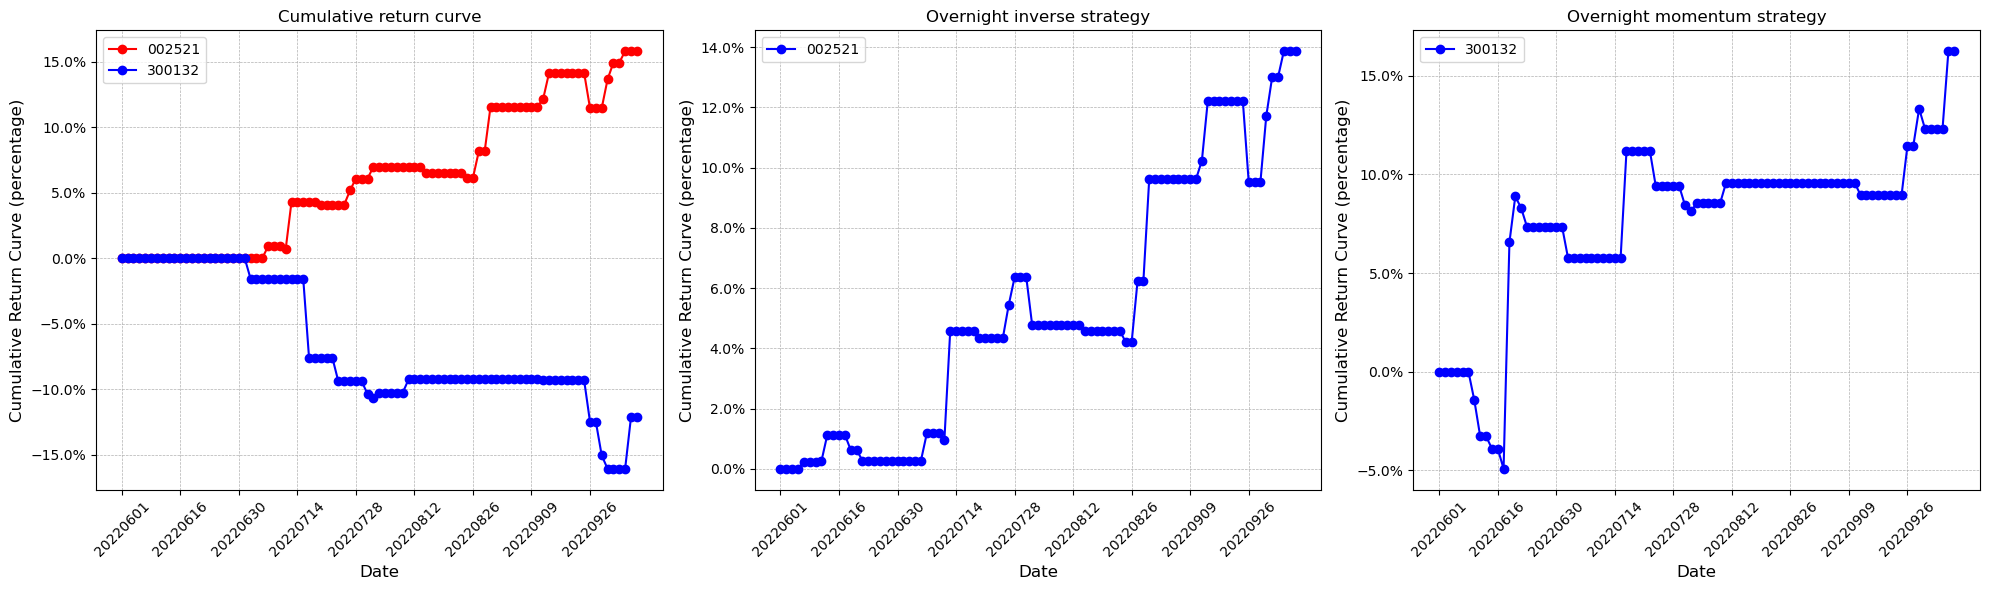

In [575]:
def ovnintradayinversetrading(row, tc=0.0014 + 0.002):
    if row["ovnreturn"].iloc[0] > 0.006:
        return -row["return"].sum() - tc
    if row["ovnreturn"].iloc[0] < -0.006:
        return row["return"].sum() - tc
    return 0

def ovnintradaymomentumtrading(row, tc=0.0014 + 0.002):
    if row["ovnreturn"].iloc[0] > 0.006:
        return row["return"].sum() - tc
    if row["ovnreturn"].iloc[0] < -0.006:
        return -row["return"].sum() - tc
    return 0

def ovnintradaytrading(row, tc=0.0014 + 0.002):
    if row["rolling_corr"].iloc[0] > 0.:
        return ovnintradaymomentumtrading(row, tc)
    if row["rolling_corr"].iloc[0] < 0:
        return ovnintradayinversetrading(row, tc)
    return 0

def get_rtn(id="002521", strategy="ovnintradaytrading"):
    df, _ = get_data(id)
    df["rolling_corr"] = df.index.get_level_values("Date").map(rolling_corr(df["return"].groupby(level="Date").sum().shift(1), df["ovnreturn"].groupby(level="Date").apply(lambda row: row.iloc[0]).shift(1)).rolling(window=10).mean())
    if strategy == "ovnintradaytrading":
        rtn = df.groupby(level="Date").apply(ovnintradaytrading)
    if strategy == "ovnintradaymomentumtrading":
        rtn = df.groupby(level="Date").apply(ovnintradaymomentumtrading)
    if strategy == "ovnintradayinversetrading":
        rtn = df.groupby(level="Date").apply(ovnintradayinversetrading)
    return rtn

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
_,axes = plt.subplots(1,3, figsize=(20, 6))
rtn1 = get_rtn(id="002521")
rtn2 = get_rtn(id="300132")
axes[0].plot(rtn1.cumsum(), label="002521", color="red", marker="o")
axes[0].plot(rtn2.cumsum(), label="300132", color="blue", marker="o")
axes[0].set_xlabel("Date", fontsize=12)
axes[0].set_ylabel("Cumulative Return Curve (percentage)", fontsize=12)
axes[0].grid(True, linestyle="--", linewidth=0.5)
axes[0].legend()
axes[0].set_title("Cumulative return curve", fontsize=12)
axes[0].set_xticks(range(0,len(rtn1.index),10),labels = rtn1.index[::10], rotation=45)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

rtn3 = get_rtn(id="002521", strategy="ovnintradayinversetrading")
axes[1].plot(rtn3.cumsum(), label="002521", color="blue", marker="o")
axes[1].set_xlabel("Date", fontsize=12)
axes[1].set_ylabel("Cumulative Return Curve (percentage)", fontsize=12)
axes[1].grid(True, linestyle="--", linewidth=0.5)
axes[1].legend()
axes[1].set_title("Overnight inverse strategy", fontsize=12)
axes[1].set_xticks(range(0,len(rtn3.index),10),labels = rtn3.index[::10], rotation=45)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

rtn4 = get_rtn(id="300132", strategy="ovnintradaymomentumtrading")
axes[2].plot(rtn4.cumsum(), label="300132", color="blue", marker="o")
axes[2].set_xlabel("Date", fontsize=12)
axes[2].set_ylabel("Cumulative Return Curve (percentage)", fontsize=12)
axes[2].grid(True, linestyle="--", linewidth=0.5)
axes[2].legend()
axes[2].set_title("Overnight momentum strategy", fontsize=12)
axes[2].set_xticks(range(0,len(rtn4.index),10),labels = rtn4.index[::10], rotation=45)
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()


In addition to the strategy discussed earlier, I also tested the overnight inverse strategy for stock "002521" and the overnight momentum strategy for stock "300132".

From the figure above, we can observe that 
- during the back-testing period, the strategy performed quite well for "002521" but did not yield favorable results for "300132". 
- compared to Figure 3, this discrepancy might be due to incorrectly identifying the sentiment conditions.

This suggests that relying solely on naive historical quasi-correlation to predict future sentiment remains problematic. 

Therefore, it's important to explore better sentiment prediction methods. Fortunately, there is extensive research in the literature proposing various types of proxy variables for market sentiment that can be utilized and tested in further studies.

## High frequency inverse phenomina

I discovered a micro-market phenomenon occurring at a 1-minute frequency: there is often a significant positive return immediately following a substantial negative return that deviates significantly from zero, and vice versa.

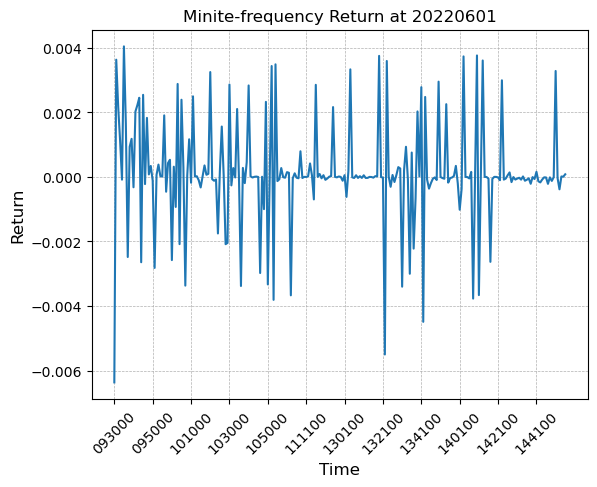

In [576]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

date = "20220601"
df = get_data("002521", freq="1min")[0]
plt.plot(df.xs(date, level="Date")["return"])
plt.xlabel("Time", fontsize=12)
plt.ylabel("Return", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(df.xs(date, level="Date").index[::20], rotation=45)
plt.title(f"Minite-frequency Return at {date}")
plt.show()

Based on the figure above, we observe that after a positive return with an absolute value greater than 0.002, there is immediately a negative return with an absolute value also greater than 0.002. To test my finding, I design a trading strategy:(inverse trading strategy)

- Buy Position: Purchase the stock at the beginning of one minite when the last-minite return is less than -0.002 and sell it at the end of the minite.

- Short Position: Sell short the stock at the beginning of one minite  when the last-minite return is greater than 0.002 and buy it back at the end of the minite.

I conducted tests under two scenarios: one without transaction costs, and the other with transaction costs of 14 bps.


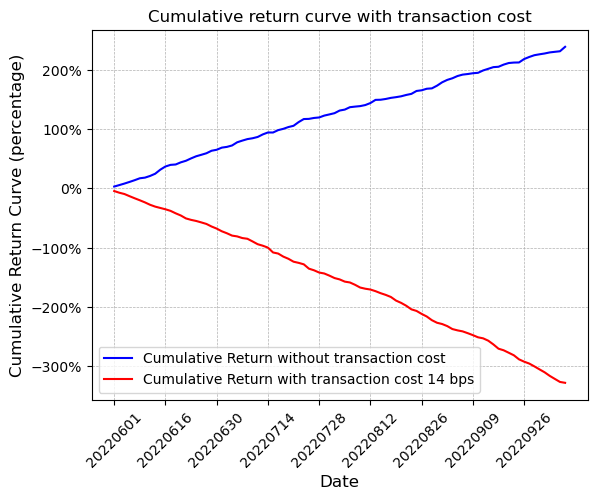

In [577]:
def inversetrading(row, tc = 0.0014 + 0.002):
    row["delay_return"] = row["return"].shift(-1).fillna(0)
    return (row[row["return"] < -0.002]["delay_return"] - tc).sum() + (-row[row["return"] > 0.002]["delay_return"] - tc).sum()


import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
rtn1 = df.groupby(level="Date").apply(lambda row: inversetrading(row, tc=0))
rtn2 = df.groupby(level="Date").apply(lambda row: inversetrading(row, tc=0.0014))
plt.plot(rtn1.cumsum(), label="Cumulative Return without transaction cost", color="blue")
plt.plot(rtn2.cumsum(), label="Cumulative Return with transaction cost 14 bps", color="red")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return Curve (percentage)", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.title("Cumulative return curve with transaction cost", fontsize=12)
plt.xticks(range(0,len(rtn1.index),10),labels = rtn1.index[::10], rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()

Based on the figure above, we can observe:

- Sability: The curve representing the scenario without transaction costs demonstrates that the micro-market phenomenon is very stable.
- Sensitivity to Transaction Costs: The phenomenon is highly sensitive to the level of transaction costs applied.

However, this phenomenon could be exploited to generate profits by 
- trading in markets with much lower transaction costs;
- carefully using limit orders to avoid the costs associated with the bid-ask spread.
